# Try `GeluSigmoid` learning

Observations from `g_true.ipynb` show that on the domain $x\in [0,1]$ the range $g(x)$ achieves max and min values outside $[-1,1]$. 
Which exceeds the output range of `tanh` outlayer in `Gelu`

In [1]:
import torch 
import numpy as np

from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler

from data.budworm import simulate_trials
from stabnode.utils import set_global_seed
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('ggplot')


seed = 1234
set_global_seed(seed=seed)


savefigs = True
folder = "figures_g_sigmoid/"

## Generate data for each trial

In [2]:
from sympy import symbols, Eq, solve, simplify

r, k = symbols('r k', positive=True)
a = r/k
b = -r
c = (k+r)/k
d = -r
p = (3*a*c-b**2) / (3*a**2)
q = (2*b**3 - 9*a*b*c+27*a**2*d) / (27*a**3)

D = - (4*p**3 + 27*q**2)
D = simplify(D)


D_fixed = D.subs(r, 0.56)
r1, r2 = solve(Eq(D_fixed, 0), k)
print(r1,r2)

k1 = r1-1.1
k2 = r2+1.1

def smooth_k(t):
    A = (k2-k1)/2
    return A*np.sin(t-np.pi/2)+A + k1

def smooth_k_torch(t):
    A = (k2-k1)/2
    return A*torch.sin(t-torch.pi/2) + A + k1

6.44569072482332 9.93441120446710


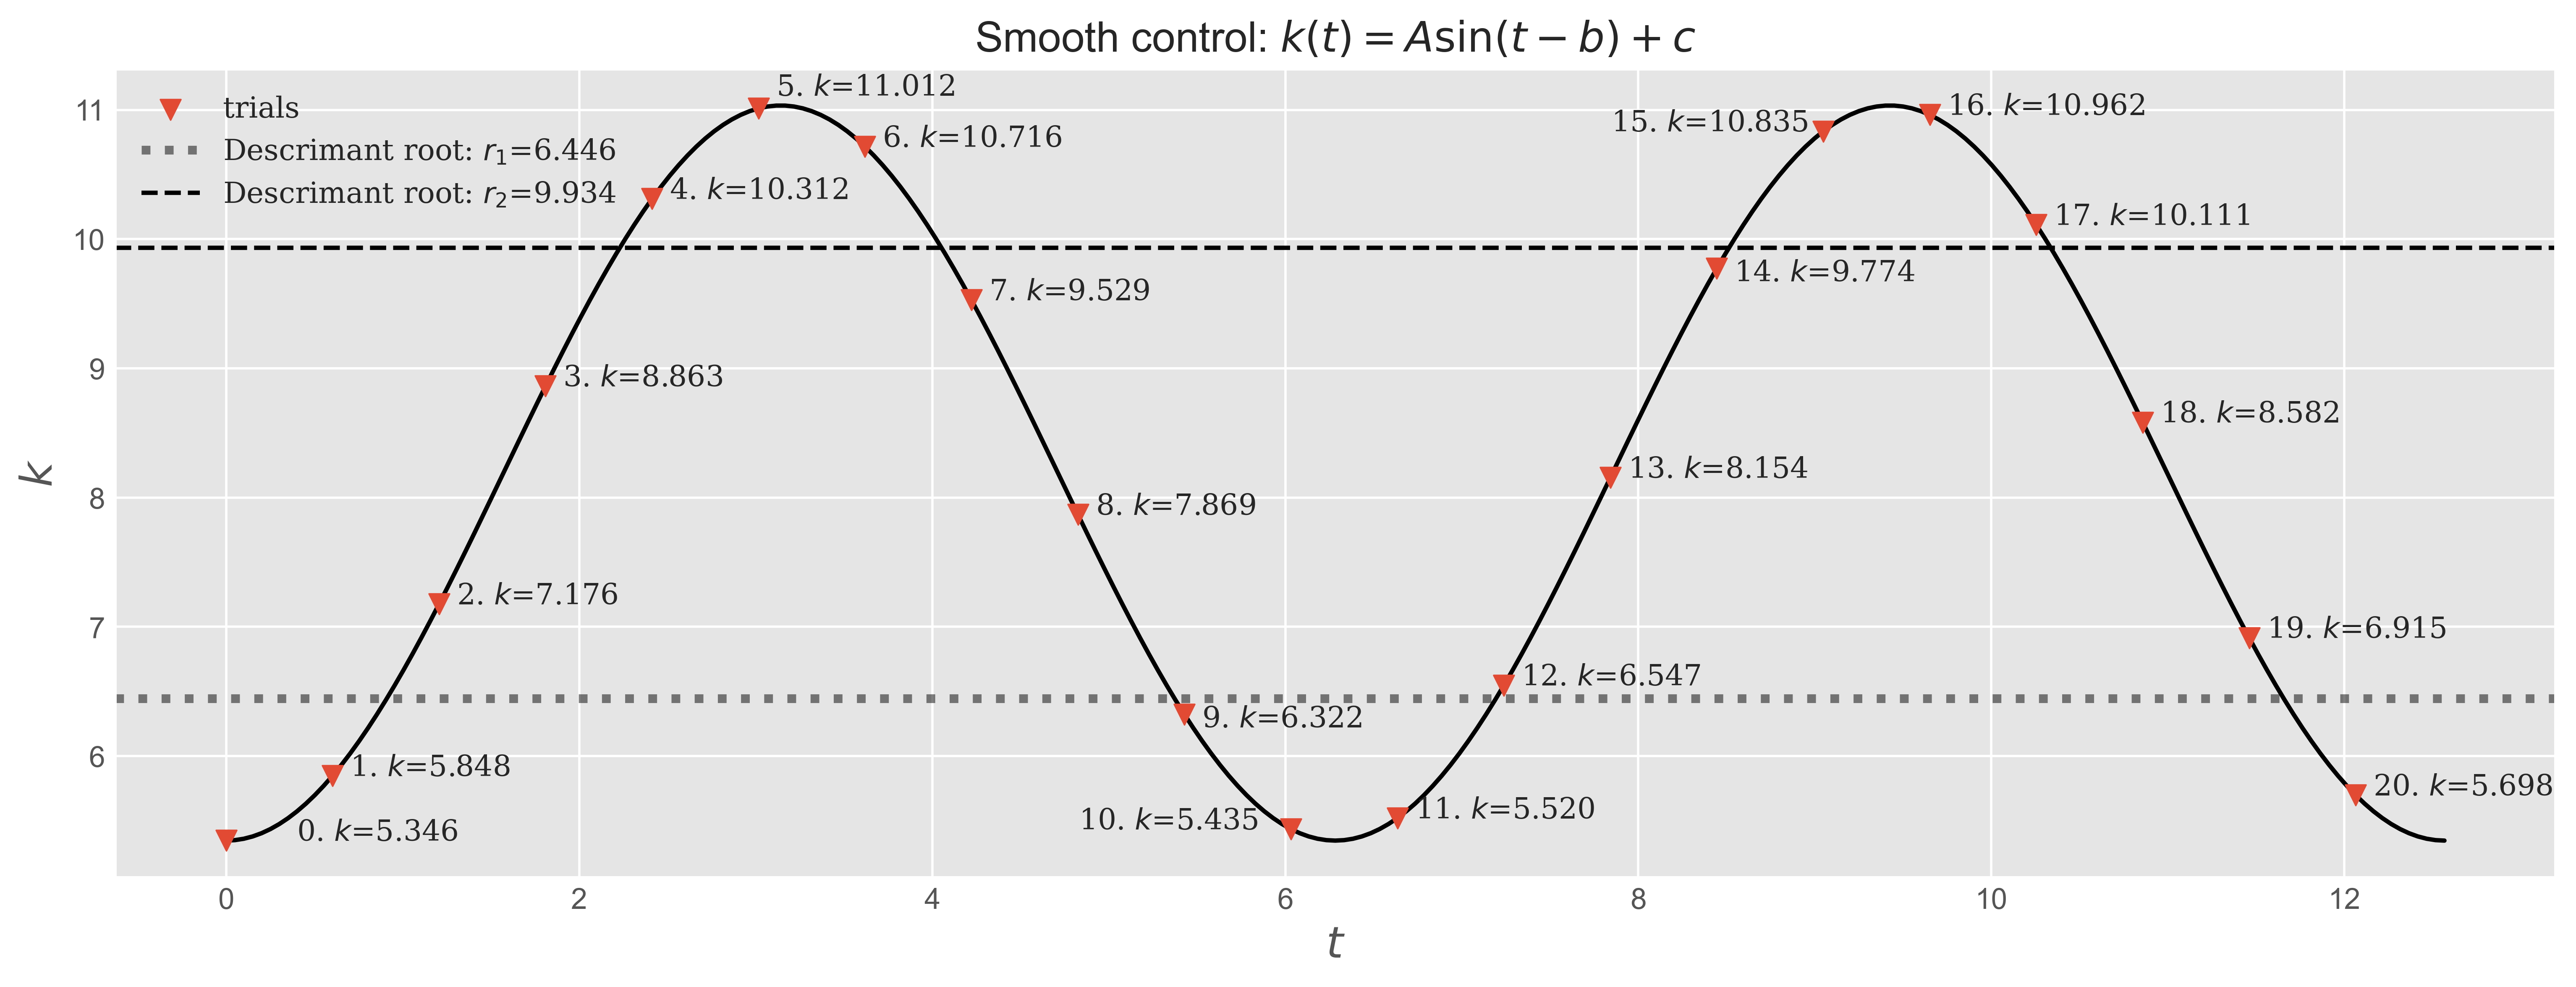

In [3]:
sample_rate = 12
t_span = np.linspace(0,4*np.pi,251)
t_trials = t_span[::sample_rate]
k_true = smooth_k(t_span)
k_trials = smooth_k(t_trials)


fig, ax = plt.subplots(1,1,figsize=(15,5),dpi=500)
t_span = np.linspace(0,4*np.pi,251)

ax.plot(t_span, k_true,c='black',zorder=1)
ax.scatter(
    t_span[::sample_rate],
    k_trials,
    label='trials',
    marker='v',
    s=50,
    zorder=2
)

for idx, (x,y) in enumerate(zip(t_span[::sample_rate],k_trials)):
    x_buff = 0.1
    if idx == 10 or idx == 15:
        x_buff = -1.2
    if idx == 0:
        x_buff = 0.4

    y_buff = 0
    if idx == 9 or idx == 14:
        y_buff = -0.1
    
    if idx == 5:
        y_buff = 0.1
    ax.text(x+x_buff,y+y_buff,s=rf'{idx}. $k$={y:.3f} ',family='serif',zorder=3)

ax.grid(True)
ax.axhline(r1,linestyle=':',c='black', alpha=0.5,label=rf"Descrimant root: $r_1$={r1:.3f}",lw=3,zorder=1)
ax.axhline(r2, linestyle='--',c='black', label=rf"Descrimant root: $r_2$={r2:.3f}",zorder=1)
ax.set_ylabel(r"$k$", size=15)
ax.set_xlabel(r"$t$",size=15)
ax.set_title(r"Smooth control: $k(t) = A\sin(t-b)+c$")
ax.legend(prop={'family':'serif'})
if savefigs:
    plt.savefig(folder+f"budworm_smooth_control_{len(k_trials)}_k_trials.pdf")
plt.grid(True)
plt.show()

In [4]:
from data.budworm import simulate_trials, budworm_steady_states
import pickle

In [5]:
xs = np.linspace(0.1, 10, 51)

In [6]:
# trials = {}


# for idx, ki in tqdm(enumerate(k_trials)):

#     ki_traj = []
#     ki_times= []

#     for x0 in tqdm(xs):
#         trial_ki = simulate_trials([ki],x0,dt=0.2,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501,show_progress=False)
#         ti = trial_ki.t_vals[0]
#         xi = trial_ki.x_vals[0]

#         ki_traj.append(xi)
#         ki_times.append(ti)

#     trials[f"trial_{idx}"] = {
#         "traj": ki_traj,
#         "times": ki_times,
#         "k": ki, 
#         "trial": idx
#     }


In [7]:
# path = "trials.pkl"

# with open(path, 'wb') as file:
#     pickle.dump(trials,file)

In [8]:
path = 'trials.pkl'

with open(path, 'rb') as file:
    trials = pickle.load(file)

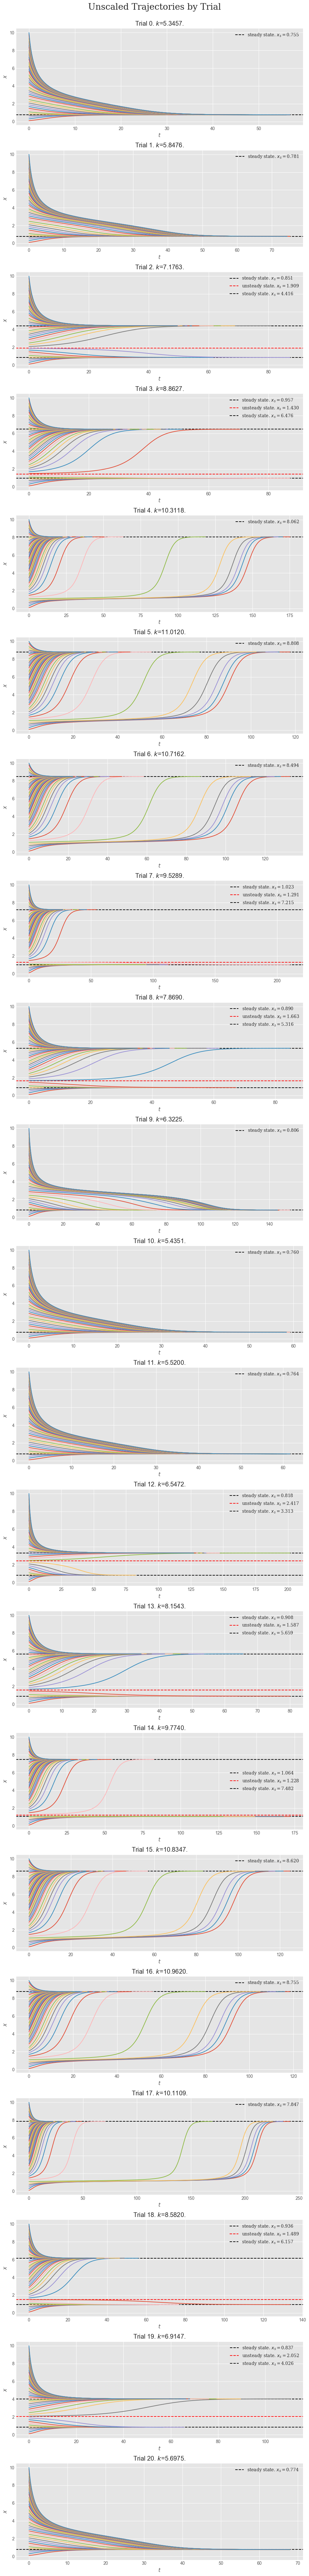

In [9]:
cols = 1
rows = len(trials)

fig, axs = plt.subplots(rows, cols, figsize=(10*cols, 4*rows))

axs = axs.flatten()

for idx in range(rows):
    ax = axs[idx]
    trial_i = trials[f"trial_{idx}"]

    times = trial_i["times"]
    traj = trial_i["traj"]
    ki = trial_i["k"]

    for ti, xi in zip(times, traj):
        ax.plot(ti,xi)

    for idx2,xsi in enumerate(budworm_steady_states(ki,r=0.56)):
        label = rf"steady state. $x_s=${xsi:.3f}"
        color = 'black'
        if idx2 ==1:
            label = rf"unsteady state. $x_s=${xsi:.3f}"
            color = 'red'

        ax.axhline(
            xsi,
            xmin=0,
            c=color,
            linestyle="--",
            label=label,
            zorder=1
        )
    
    ax.set_xlabel(r"$t$")
    ax.set_ylabel(r"$x$")
    ax.set_title(rf"Trial {idx}. $k$={ki:.4f}.")
    ax.legend(prop={'family':'serif'})




plt.suptitle("Unscaled Trajectories by Trial", family='serif',size=20)
plt.tight_layout(rect=[0,0,1,0.98])

if savefigs:
    file_name = f"unscaled_trajectories_num_k_{len(k_trials)}_num_x0_{len(xs)}.pdf"
    plt.savefig(folder+file_name)

plt.show()    


# Better model Trainer

In [10]:
from stabnode.node import StabNODE
from stabnode.utils import _load_loop_wrapper
from torchode import solve_ivp
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim import Optimizer

import torch.nn as nn
import time
import copy

from typing import Callable, Optional, Tuple
from pathlib import Path

In [ ]:

def _save_model_opt_cpu(model:StabNODE, opt, epoch, loss, save_path:str, scheduler = None):
    device = next(model.parameters()).device.type
    f = model.f
    g = model.g
    f_args = f.args
    g_args = g.args

    if device  == "cpu":
        f_state = f.state_dict()
        g_state = g.state_dict()
        model_state = model.state_dict()
    else:
        f_cpu = copy.deepcopy(f).to('cpu')
        g_cpu = copy.deepcopy(g).to('cpu')
        model_cpu = StabNODE(f_cpu,g_cpu).to('cpu')

        f_state = f_cpu.state_dict()
        g_state = g_cpu.state_dict()
        model_state = model_cpu.state_dict()
    

    checkpoint = {
        "f_state_dict": f_state,
        "g_state_dict": g_state,
        "stabnode_state_dict": model_state,
        "f_args": f_args,
        "g_args":g_args,
        "opt_state_dict": opt.state_dict(),
        "epoch": epoch,
        "loss": loss,}

    if scheduler is not None:
        checkpoint["scheduler_state_dict"] = scheduler.state_dict()
    

    torch.save(checkpoint,save_path)
    
def _save_log_history(
        losses,
        times,
        stopping_criteria,
        best_model_epoch,
        method_status,
        patience_hist,
        lr_hist,
        save_path:str = None,
):
    log_history = {
        "losses": losses,
        "times": times,
        "stopping_criteria": stopping_criteria,
        "best_model_epoch": best_model_epoch,
        "method_status": method_status,
        "patience_hist": patience_hist,
        "lr_hist": lr_hist
    }

    if save_path is not None:
        with open(save_path, 'wb') as f: 
            pickle.dump(log_history, f)
    
    return log_history


def _create_save_paths(folder: str | Path):
    if folder is None:
        return None, None
    
    base_path = Path(folder)
    base_path.mkdir(parents=True, exist_ok=True)  

    
    model_opt_path = base_path / "model_opt_states.pt"
    log_path = base_path / "log_hist.pkl"

    return str(model_opt_path), str(log_path)


In [12]:
def model_trainer(
        model: StabNODE,
        opt: torch.optim.Optimizer,
        loss_criteria: Callable,
        train_loader: torch.utils.data.DataLoader,
        n_epochs: int,
        control: Callable[[torch.Tensor], torch.Tensor],
        min_improvement:float,
        patience: int,
        solve_method: str='tsit5', 
        save_folder: str|Path=None,
        show_progress:bool=True,
        scheduler: Optional[torch.optim.lr_scheduler._LRScheduler]=None,
        print_every: int=5,
        _precision: int = 4
)-> Tuple[StabNODE,dict]:
    
    loop_wrapper = _load_loop_wrapper(show_progress)
    model_opt_save_path, log_save_path = _create_save_paths(save_folder)

    best_loss = torch.inf
    patience_count = 0
    best_model_epoch = -1
    stopping_criteria = 'max-epochs'

    losses = []
    times = []
    status = []
    patience_hist = []
    lr_hist = []
    model.train()
    for epoch in loop_wrapper(range(n_epochs)):
        t1 = time.time()
        epoch_loss = 0.0
        num_batches = 0
        epochs_status = []
        
        for Xi, Ti, x0i in train_loader:
            Xi = Xi.squeeze() # [batch, time, dim]
            Ti = Ti.squeeze()
            x0i = x0i.reshape(-1,1)

            if not x0i.requires_grad:
                x0i = x0i.clone().detach().requires_grad_()


            opt.zero_grad()

            sol = solve_ivp(
                f=lambda t, x: model(t, x, control),
                y0=x0i,
                t_eval=Ti,
                method=solve_method
            )

            epochs_status.append(sol.status)
            Xi_pred = sol.ys.squeeze()
            loss = loss_criteria(Xi_pred, Xi)

            loss.backward()
            opt.step()
            epoch_loss += loss.item()
            num_batches += 1

        
        epoch_loss = epoch_loss / num_batches
        if scheduler is not None:
            scheduler.step(epoch_loss)

        cur_lr = opt.param_groups[0]['lr']
        epoch_time = time.time() - t1

        losses.append(epoch_loss)
        times.append(epoch_time)
        status.append(epochs_status)
        lr_hist.append(cur_lr)

        if show_progress:
            if epoch <= 5 or epoch % print_every == 0:
                print(f"Epoch {epoch}: Loss: {epoch_loss:.{_precision}f}. time = {epoch_time:.{_precision}f}s. lr = {cur_lr:.{_precision}f}")    
        
        # model checks
        if best_loss - epoch_loss >= min_improvement:
            best_loss = epoch_loss
            patience_count = 0
            best_model_epoch = epoch

            if save_folder is not None:
                _save_model_opt_cpu(
                    model,
                    opt,
                    best_model_epoch,
                    best_loss,
                    model_opt_save_path,
                    scheduler
                )

        else:
            patience_count += 1
        
        patience_hist.append(patience_count)

        if patience_count > patience:
            stopping_criteria = 'early-stoppage'
            if show_progress is not None:
                print(f"Patience exceeded: {patience}. Early stoppage executed.")
            break
        
        if save_folder is not None:
            _ = _save_log_history(
                losses,
                times,
                stopping_criteria=f"checkpoint-{epoch}",
                best_model_epoch=best_model_epoch,
                method_status=status,
                patience_hist=patience_hist,
                lr_hist=lr_hist,
                save_path = log_save_path
            )
        
    log_history = _save_log_history(
        losses,
        times,
        stopping_criteria,
        best_model_epoch,
        status,
        patience_hist,
        lr_hist,
        log_save_path,
    )

    return model, log_history

## test batching by trial

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
trail_0 = trials["trial_0"]

xs = trail_0['traj']
ts = trail_0['times']

scaler = MinMaxScaler()

scaler.fit(np.concatenate(xs).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

In [15]:
scaler.data_max_, scaler.data_min_

(array([10.]), array([0.1]))

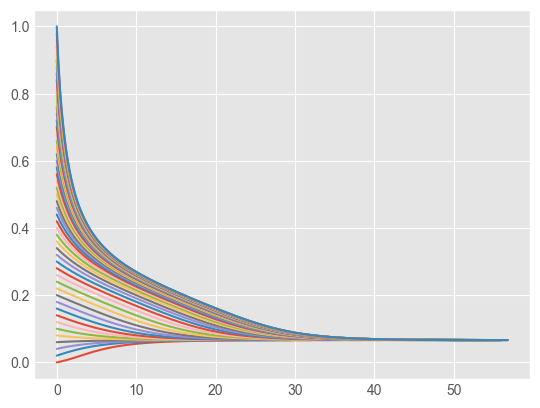

In [16]:
for ti, xi in zip(ts, xs_scaled):
    plt.plot(ti,xi)
plt.show()

In [17]:
for ti in ts:
    print(len(ti),end=' ')

161 149 137 101 125 149 161 173 181 193 205 213 225 233 237 245 249 257 257 261 261 265 269 269 269 273 273 277 277 273 277 277 277 277 277 281 281 281 281 281 281 281 285 281 281 281 285 281 285 285 285 

In [18]:
x0 = torch.tensor(
    [xi[0] for xi in xs_scaled], dtype=torch.float32
).reshape(-1,1)

In [19]:
t_max = None
t_max_len = -1
t_max_idx = -1
for t_idx, ti in enumerate(ts):
    if len(ti) > t_max_len:
        t_max = ti
        t_max_len = len(ti)
        t_max_idx = t_idx
t_max_len, t_max_idx

(285, 42)

In [20]:
t_max = torch.tensor(t_max,dtype=torch.float32)

In [21]:
import importlib

import stabnode

importlib.reload(stabnode)

from stabnode.node import GeluSigmoid, FeluSigmoid, StabNODE, Gelu
from stabnode.utils import set_global_seed



seed = 1234
set_global_seed(seed=seed)

In [22]:
# num_traj = len(xs)

In [23]:
# bounds determined by `g_true.ipynb`

f = FeluSigmoid(1,1,6,lower_bound=-0.5,upper_bound=-0.1)
g = GeluSigmoid(2,1,6,lower_bound=-5,upper_bound=1.1)
g_old = Gelu(2,1,6)

model = StabNODE(f,g)

In [24]:
# t_test = torch.tensor([[1]],dtype=torch.float32)
# x_test = torch.tensor([[1]],dtype=torch.float32)

# def control_func(t):
#     return torch.tensor(smooth_k_torch(t_test),dtype=torch.float32).unsqueeze(0)



# model(t_test,x_test,control_func)


In [25]:
# y0 = torch.tensor(xs[t_max_idx][0],dtype=torch.float32).reshape(-1,1)
# y0

In [26]:
# t_eval = torch.tensor(ts[t_max_idx],dtype=torch.float32)
# t_eval.squeeze()

In [27]:
# model(t_eval[0],y0,control_func)

In [28]:
# u = control_func(t_eval[0])
# g(y0[0],u), g_old(y0[0],u)

In [29]:
# xu = torch.cat([y0[0],u],dim=-1)
# xu

In [30]:
# solve_method = 'tsit5'

# sol = solve_ivp(
#     f = lambda t,x: model(t,x,control_func),
#     y0=y0,
#     t_eval=t_eval,
#     method=solve_method
# )

In [31]:
# plt.plot(sol.ts.squeeze(),sol.ys.squeeze().detach().numpy())

# Learning with `GeluSigmoid` and `FeluSigmoid`

increased dimensionality as well `hidden_dim = 6` for both
f_bounds $-0.5$ and $-0.1$ and g_bounds ($-5$ and $1.1$)

In [32]:
import torch.nn as nn
from typing import List
device = 'cpu'

In [33]:
k_trials[0]

5.34569072482332

### control func & `Dataset`

In [34]:

def control_func(t):
    return torch.tensor(k_trials[0],dtype=torch.float32).unsqueeze(0)
    # return torch.tensor(smooth_k_torch(t),dtype=torch.float32).unsqueeze(0)

class TrialsDataset(torch.utils.data.Dataset):
    def __init__(self, x_trials:List, t_trials:List,):
        self.x_trials = x_trials             # shape [T_total, d]
        self.t_trials = t_trials              # shape [T_total]

    def __len__(self):
        return len(self.x_trials) 

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.__len__():
            raise IndexError(
                f"Index {idx} is out of bounds of dataset size: {self.__len__()}."
            )
        
        
        Xi = self.x_trials[idx]                                          
        ti = self.t_trials[idx]  
        x0 = Xi[0]           

        return Xi,ti,x0


## Non bifurcation case (trial 0)

### data

In [35]:

trail_0 = trials["trial_0"]
print("k =",k_trials[0])

xs = trail_0['traj']
ts = trail_0['times']

scaler = MinMaxScaler()
scaler.fit(np.concatenate(xs).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

k = 5.34569072482332


In [36]:
xs_scaled_torch = [
    torch.tensor(traj,dtype=torch.float32,device=device)
    for traj in xs_scaled
]

ts_torch = [
    torch.tensor(ti,dtype=torch.float32,device=device)
    for ti in ts
]

In [37]:
train_dataset = TrialsDataset(xs_scaled_torch, ts_torch)

train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True, batch_size=1, num_workers=0)

## 
pass x through some transform. 
 - const f and g 
 - const g and vary f 
 - const 

 lr, batchsize, epochs, num trajs

In [38]:
n_epochs = 20
lr = 1e-3
show_progress = True
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters())+list(g.parameters()), lr = lr)
# scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.1,patience=5)

In [50]:
model, log_hist =  model_trainer(
    model,
    opt,
    loss_criteria,
    train_loader,
    n_epochs,
    control_func,
    min_improvement=1e-6,
    patience=10,
    solve_method=solve_method,
    scheduler=scheduler,
    # save_folder="test_50_epochs_model",
    print_every=1,
    _precision = 7
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: Loss: 0.0044297. time = 18.2710490s. lr = 0.0010000
Epoch 1: Loss: 0.0044213. time = 17.9454710s. lr = 0.0010000
Epoch 2: Loss: 0.0044155. time = 17.5036280s. lr = 0.0010000
Epoch 3: Loss: 0.0044096. time = 18.1201150s. lr = 0.0010000
Epoch 4: Loss: 0.0044080. time = 17.6683581s. lr = 0.0010000
Epoch 5: Loss: 0.0044017. time = 17.4702299s. lr = 0.0010000
Epoch 6: Loss: 0.0043959. time = 17.8991911s. lr = 0.0010000


KeyboardInterrupt: 

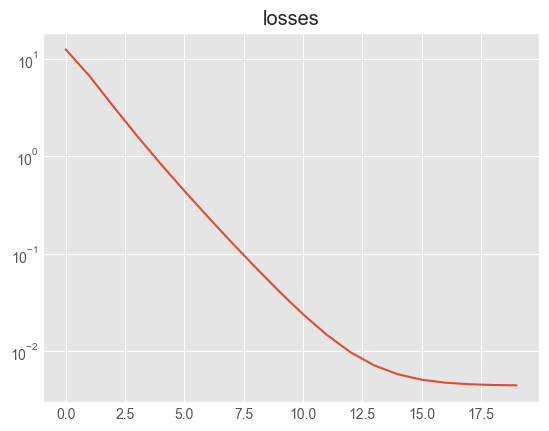

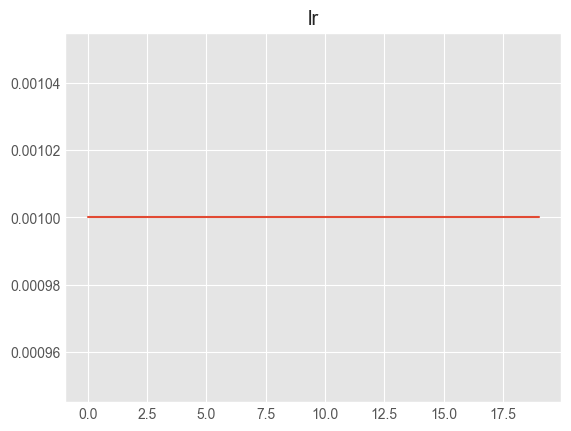

In [40]:
plt.title("losses")
plt.plot(log_hist["losses"])
plt.yscale('log')
plt.show()

plt.title("lr")
plt.plot(log_hist["lr_hist"])
plt.show()

## Learned trajectories

In [41]:
g_eval = model.g.eval()
f_eval = model.f.eval()

model_eval = StabNODE(f_eval,g_eval)

In [42]:
scaled_steady_states = scaler.transform(np.array(budworm_steady_states(k_trials[0],r=0.56)).reshape(-1,1)).reshape(-1)

  0%|          | 0/51 [00:00<?, ?it/s]

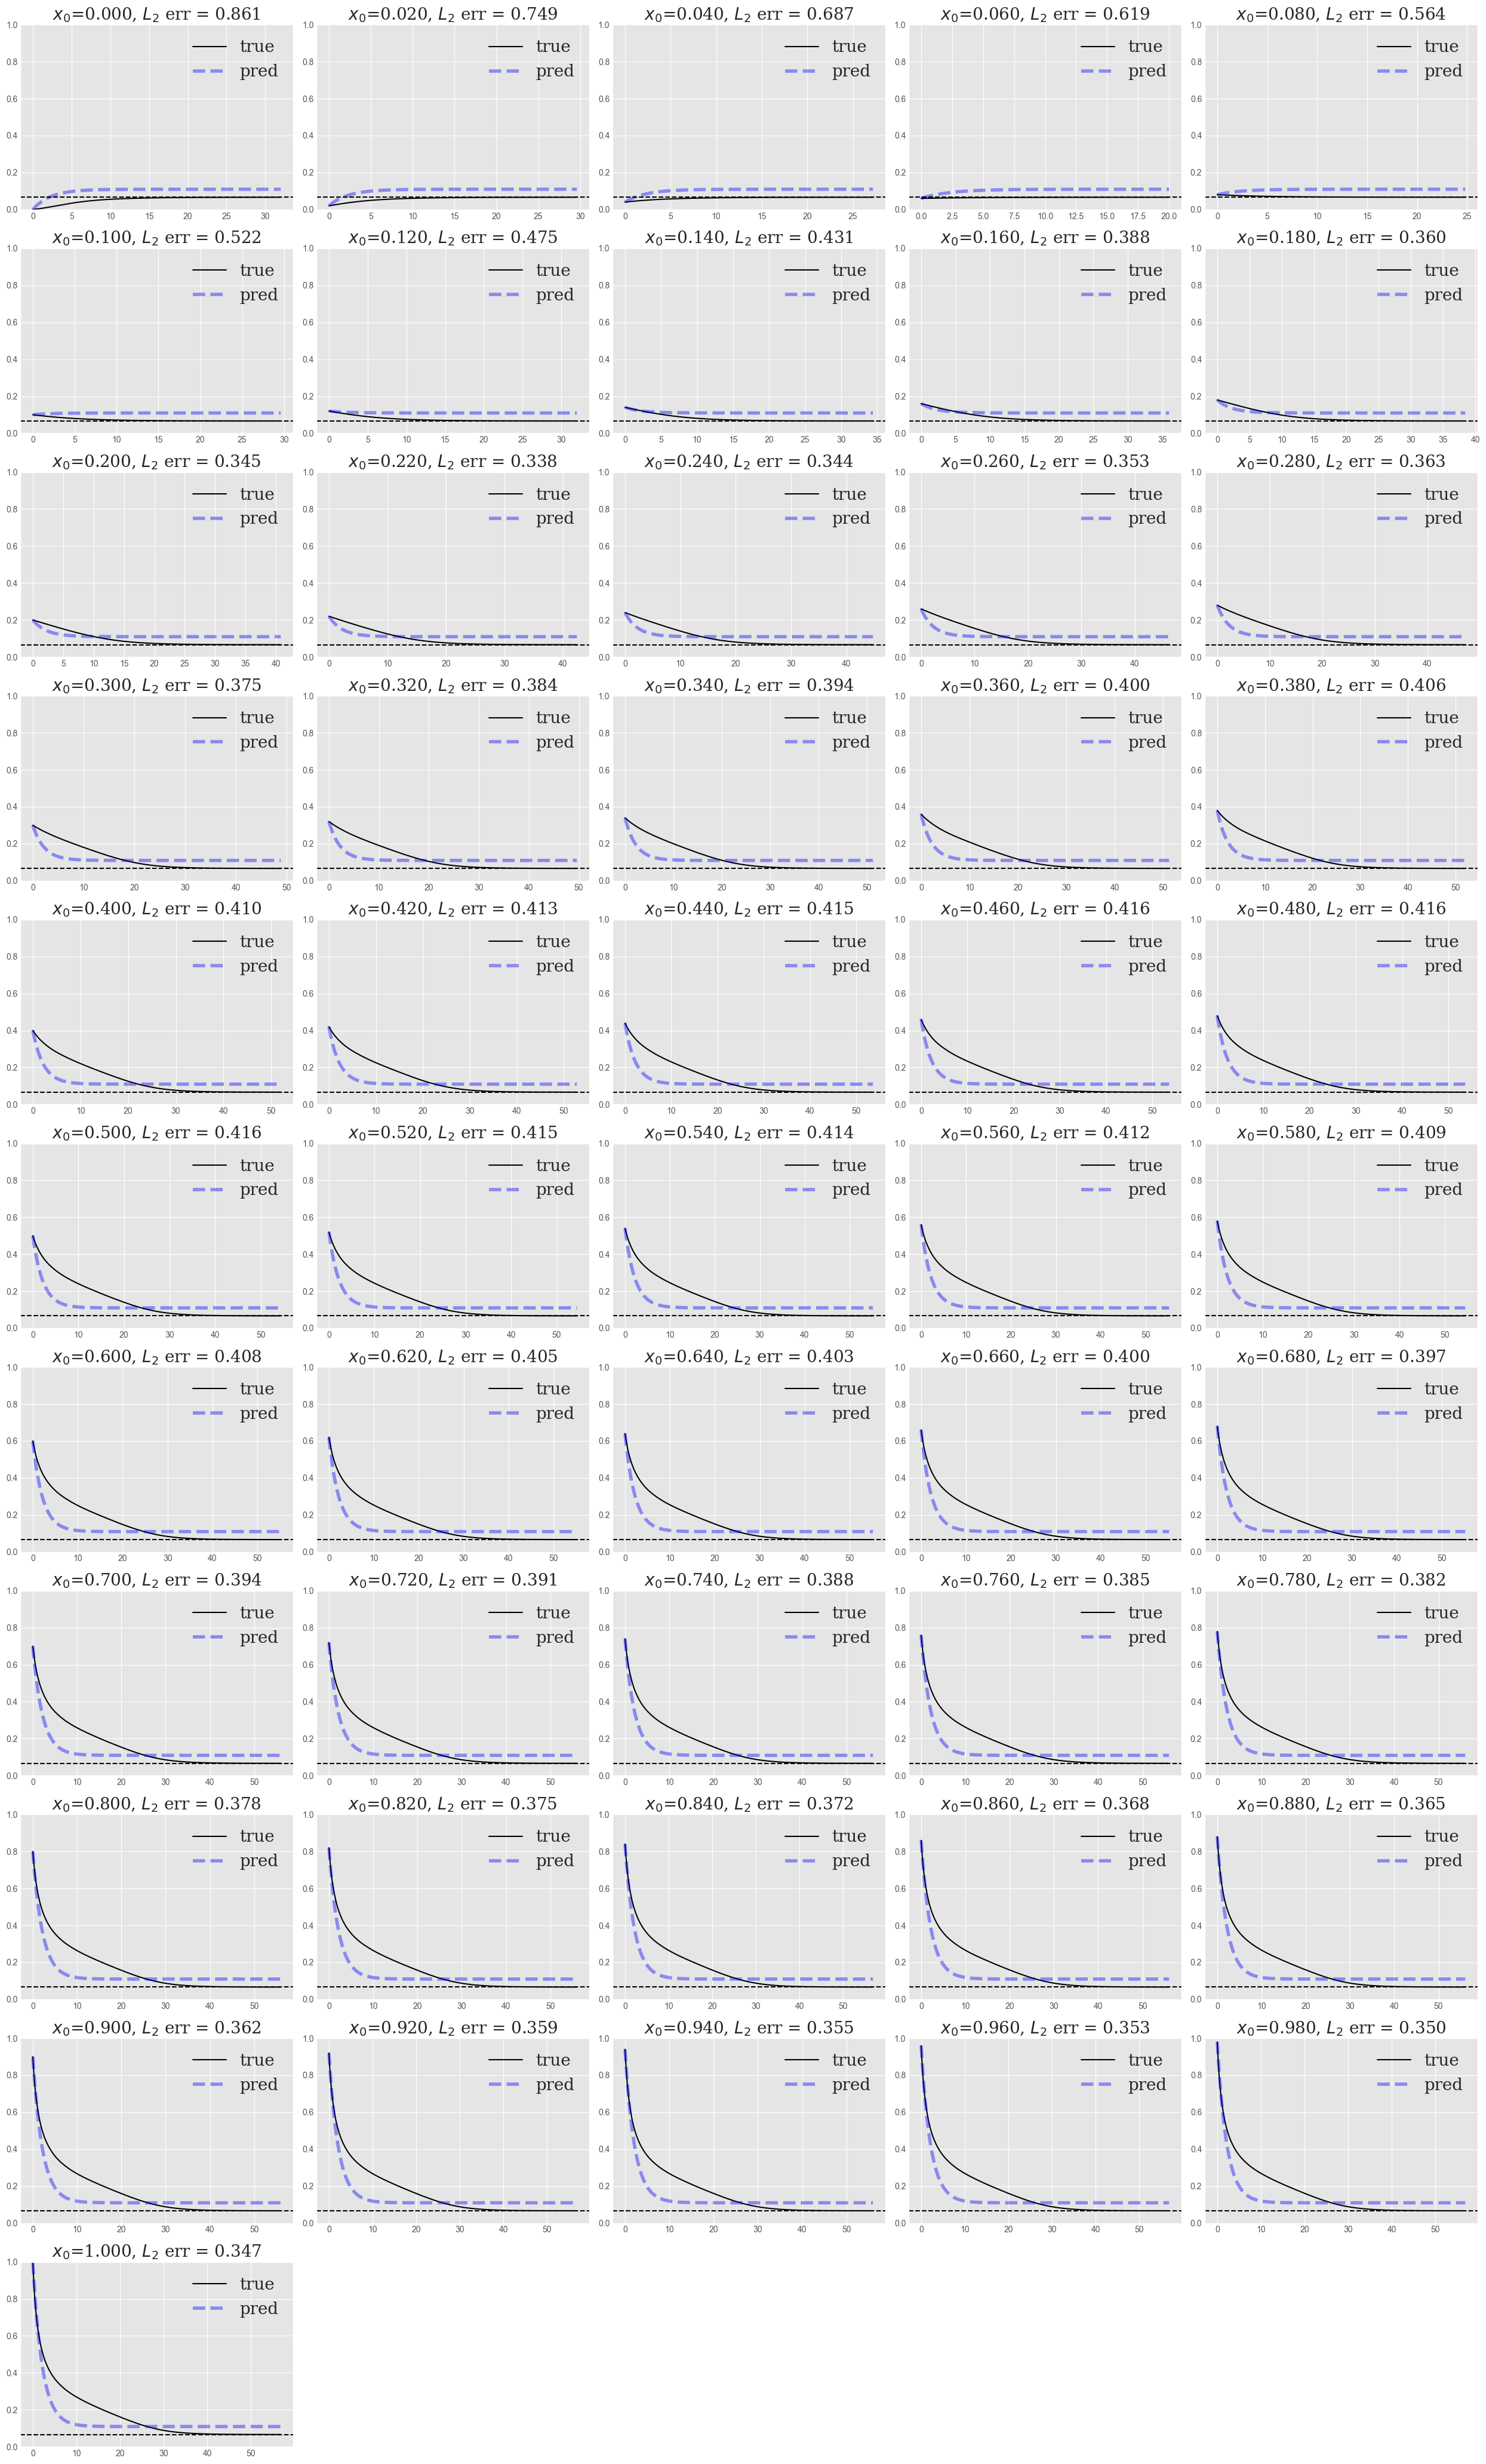

In [43]:
cols = 5
rows = int(np.ceil(len(train_dataset)/cols))

fig, axs = plt.subplots(rows, cols,figsize=(5*cols,4*rows))

axs = axs.flatten()

with torch.no_grad():
    for idx in tqdm(range(len(train_dataset))):
        ax = axs[idx]
        xi, ti, x0i = train_dataset[idx]

        sol = solve_ivp(
            f=lambda t, x: model_eval(t, x, control_func),
            y0=x0i.reshape(-1,1),
            t_eval=ti,
            method=solve_method
        )

        rel_l2_err = np.linalg.norm(sol.ys.squeeze() - xi)/np.linalg.norm(xi)

        ax.plot(ti,xi,label='true',color='black')
        ax.plot(sol.ts.squeeze(),sol.ys.squeeze(),label="pred", linestyle='--', color='blue',alpha=0.4,lw=4)
        ax.set_ylim(0,1)
        ax.set_title(rf"$x_0$={x0i:.3f}, $L_2$ err = {rel_l2_err:.3f}", family='serif',size=20)
        ax.legend(prop={'family':'serif','size':20})

        for idx,xsi in enumerate(scaled_steady_states):
            label = rf"steady state. $x_s=${xsi:.3f}"
            color = 'black'
            if idx ==1:
                label = rf"unsteady state. $x_s=${xsi:.3f}"
                color = 'red'

            ax.axhline(
                xsi,
                xmin=0,
                c=color,
                linestyle="--",
                label=label,
                zorder=2
            )

    for idx in range(len(train_dataset), rows*cols):
        fig.delaxes(axs[idx])

plt.tight_layout(rect=[0, 0, 1, 0.94]) 


### g and f

In [44]:
from data.budworm import f_true, g_true

In [45]:
x_lin = np.linspace(0,1,101)
with torch.no_grad():
    x_lin_torch = torch.tensor(x_lin, dtype=torch.float32)
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)
    
    k_torch = torch.tensor(k_trials[0],dtype=torch.float32).reshape(-1,1)
    g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])

In [46]:
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).squeeze()

f_true_arr =  f_true(x_lin_unscaled)
g_true_arr = scaler.transform(g_true(x_lin_unscaled, k_trials[0], r=0.56).reshape(-1,1)).squeeze()

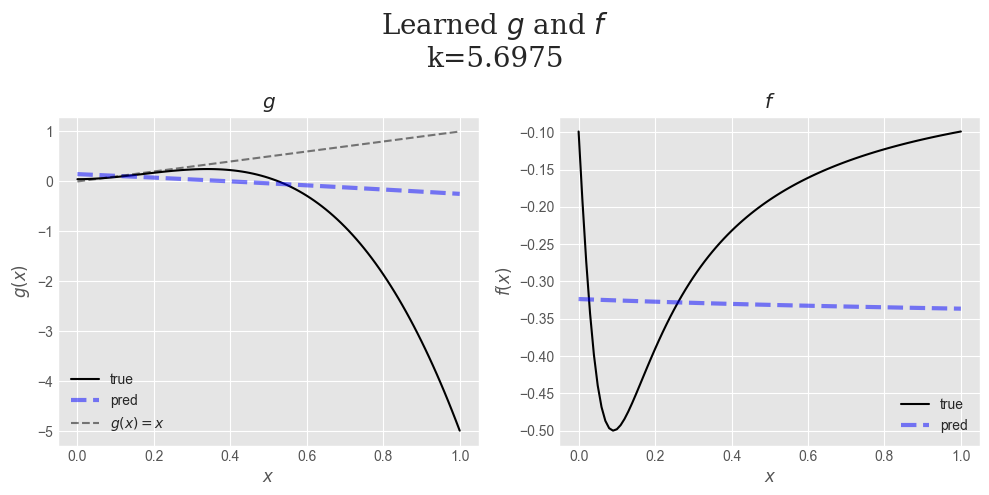

In [47]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.plot(x_lin, g_true_arr,label='true',c='black')
ax1.plot(x_lin_torch, g_pred, label='pred', linestyle='--', c='blue', alpha=0.5, lw=3)
ax1.plot(x_lin, x_lin, c='black', linestyle='--',alpha=0.5,label=r"$g(x)=x$")
ax1.set_title(r"$g$")
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$g(x)$")
# ax1.set_ylim(-0.1,1)
ax1.legend()

ax2.plot(x_lin, f_true_arr, label='true', c='black')
ax2.plot(x_lin_torch, f_pred, label='pred',linestyle='--',c='blue',lw=3,alpha=0.5)
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$f(x)$")
ax2.set_title(r"$f$")
ax2.legend()
plt.suptitle(r"Learned $g$ and $f$"+f"\nk={ki:.4f}", family='serif', size=20)
plt.tight_layout()

## bifrucaiton case

## All data

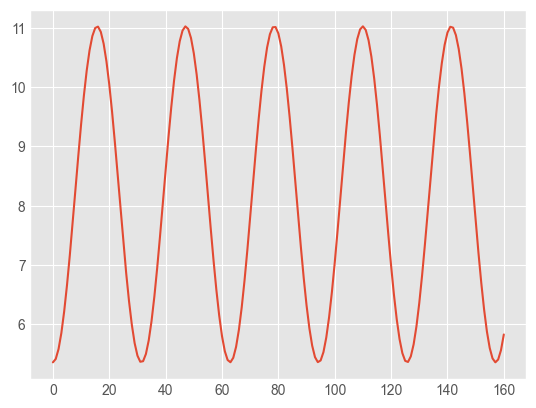

In [ ]:
# plt.plot(smooth_k(ts[0]))